# 1. Fourier Spectral Grid

In [71]:
import numpy as np
from numpy import pi, abs, max, cos, sin, tan, exp

from numpy.linalg import inv
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

In [72]:
N = 16 # Terrible things will happen if N is an odd number.

def aliased_index(i, N):
    return i - N * (i >= (N + 1)//2)

spectral_grid = np.linspace(0, 2*pi, N + 1)[:-1]
dense_grid    = np.linspace(0, 2*pi, 1000)

fourier_spectral_basis = np.array([exp(1j * aliased_index(k, N) * spectral_grid) for k in range(N)]).T
fourier_dense_basis    = np.array([exp(1j * aliased_index(k, N) * dense_grid) for k in range(N)]).T

#Here we remove the imaginary part of the Nyquist mode.
#This is equivalent to Trefethen's trick in page 19.
if N % 2 == 0: 
    fourier_dense_basis[:, N//2] = fourier_dense_basis[:, N//2].real  

## 1.1 Aliasing

Some text here


Frequencies on the grid: [ 0  1  2  3  4  5  6  7 -8 -7 -6 -5 -4 -3 -2 -1].



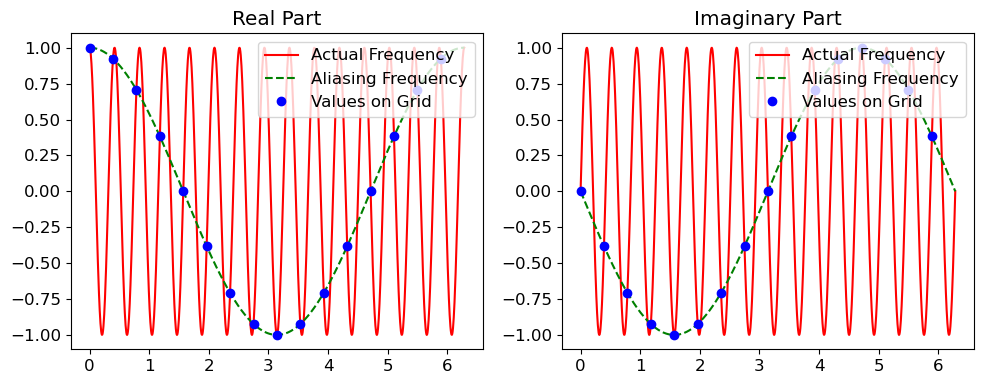

In [73]:
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

k = 15 # Try values at the Nyquist frequency N//2 and higher.

print(f'\nFrequencies on the grid: {aliased_index(np.arange(N), N)}.\n')

ax[0].set_title('Real Part')
ax[0].plot(dense_grid, exp(1j * k * dense_grid).real, 'r-', label = 'Actual Frequency')
ax[0].plot(dense_grid, exp(1j * aliased_index(k, N) * dense_grid).real, 'g--', label = 'Aliasing Frequency')
ax[0].plot(spectral_grid, fourier_spectral_basis[:, k].real, 'bo', label = 'Values on Grid')
ax[0].legend(loc = 'upper right')
ax[0].set_ylim(-1.1, 1.1)

ax[1].set_title('Imaginary Part')
ax[1].plot(dense_grid, exp(1j * k * dense_grid).imag, 'r-', label = 'Actual Frequency')
ax[1].plot(dense_grid, exp(1j * aliased_index(k, N) * dense_grid).imag, 'g--', label = 'Aliasing Frequency')
ax[1].plot(spectral_grid, fourier_spectral_basis[:, k].imag, 'bo', label = 'Values on Grid')
ax[1].legend(loc = 'upper right')
ax[1].set_ylim(-1.1, 1.1)

plt.tight_layout()

## 1.2 A very inefficient FFT

We can test that the inverse_spectral_basis matrix (multiplied by N) produces the same result as the FFT when multiplied by a function vector. In a much less efficient way than the FFT algorithm, though.

In [74]:
def is_the_same(A, B):
    return max(abs(A - B)) < 1e-12

inverse_spectral_basis = inv(fourier_spectral_basis)
f = exp(sin(spectral_grid))

actual_FFT = fft(f)
matrix_FFT = N * (inverse_spectral_basis @ f[:, None]).flatten()
is_the_same(actual_FFT, matrix_FFT)

True

## 1.3 The cardinal functions

True

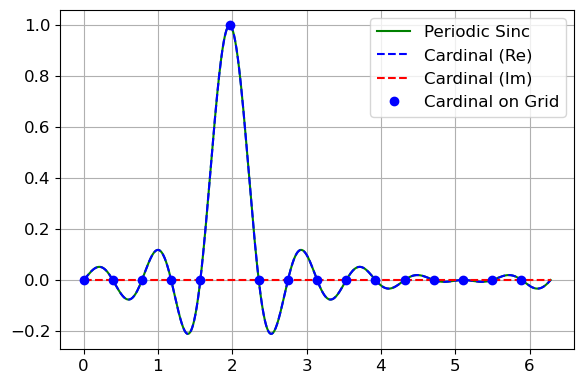

In [100]:
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

def sinc(x, N):
    return (x == 0) + sin(N * x / 2) / (N * tan(x / 2) + (x == 0))

n = 5

cardinal_spectral_functions = np.eye(N)
cardinal_dense_functions    = fourier_dense_basis @ inverse_spectral_basis

ax.plot(dense_grid,    sinc(dense_grid - spectral_grid[n], N), color = 'green', label = 'Periodic Sinc')
ax.plot(dense_grid,    cardinal_dense_functions[:, n].real, 'b--', label = 'Cardinal (Re)')
ax.plot(dense_grid,    cardinal_dense_functions[:, n].imag, 'r--', label = 'Cardinal (Im)')
ax.plot(spectral_grid, cardinal_spectral_functions[:, n], 'bo', label = 'Cardinal on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()

is_the_same(sinc(dense_grid - spectral_grid[5], N), cardinal_dense_functions[:, 5])

False

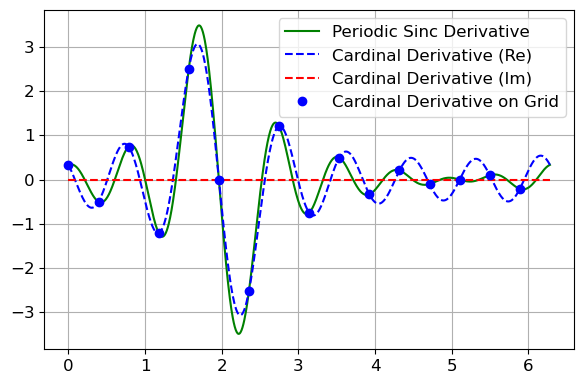

In [99]:
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

def sinc_diff(x, N):
    return 0.5 * cos(N * x / 2) / (tan(x / 2) + (x == 0)) - sin(N * x / 2) / (2 * N * sin(x / 2)**2 + (x == 0))

fourier_deriv_basis   = np.array([1j * aliased_index(k, N) * exp(1j * aliased_index(k, N) * spectral_grid) for k in range(N)]).T

#Here we kill the derivative of the Nyquist mode.
#This is equivalent to Trefethen's trick in page 19.
if N % 2 == 0: 
    fourier_deriv_basis[:, N//2] = 0

n = 5

fourier_diff_matrix  = fourier_deriv_basis @ inverse_spectral_basis
cardinal_derivatives = cardinal_dense_functions @ fourier_diff_matrix

ax.plot(dense_grid,    sinc_diff(dense_grid - spectral_grid[n], N), color = 'green', label = 'Periodic Sinc Derivative')
ax.plot(dense_grid,    cardinal_derivatives[:, n].real, 'b--', label = 'Cardinal Derivative (Re)')
ax.plot(dense_grid,    cardinal_derivatives[:, n].imag, 'r--', label = 'Cardinal Derivative (Im)')
ax.plot(spectral_grid, fourier_diff_matrix[:, n].real, 'bo',   label = 'Cardinal Derivative on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()

is_the_same(sinc_diff(dense_grid - spectral_grid[n], N), cardinal_derivatives[:, n])

## 1.4 Fourier Differentiation Matrices

In [78]:
def FourierD(N):
    x = np.linspace(0, 2*pi, N + 1)[:-1, True]
    i = np.arange(N)[:, None]
    D = (i != i.T) * 0.5 * (-1)**(i + i.T) / tan(0.5 * (x[i, 0] - x[i.T, 0]) + (i == i.T))
    return x, D

x, D = FourierD(N)
is_the_same(D, fourier_diff_matrix)

True

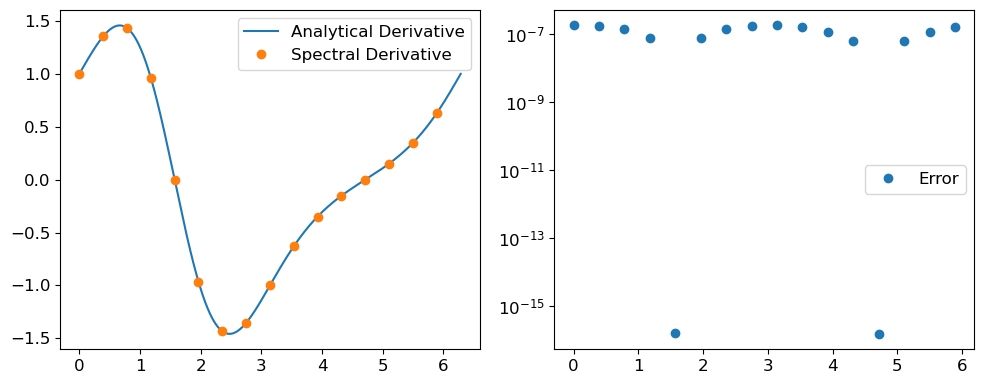

In [79]:
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

f  = exp(sin(x))
df = cos(x) * exp(sin(x))

ax[0].plot(dense_grid, cardinal_dense_functions.real @ df, label = 'Analytical Derivative')
ax[0].plot(x, D @ f, 'o', label = 'Spectral Derivative')
ax[0].legend(loc = 'upper right')

ax[1].set_yscale('log')
ax[1].plot(x, abs(D @ f - df), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()

## 1.5 FFT Differentiation


The frequencies we are considering are: [ 0  1  2  3  4  5  6  7  0 -7 -6 -5 -4 -3 -2 -1].
Notice we have removed the asymetric Nyquist mode.



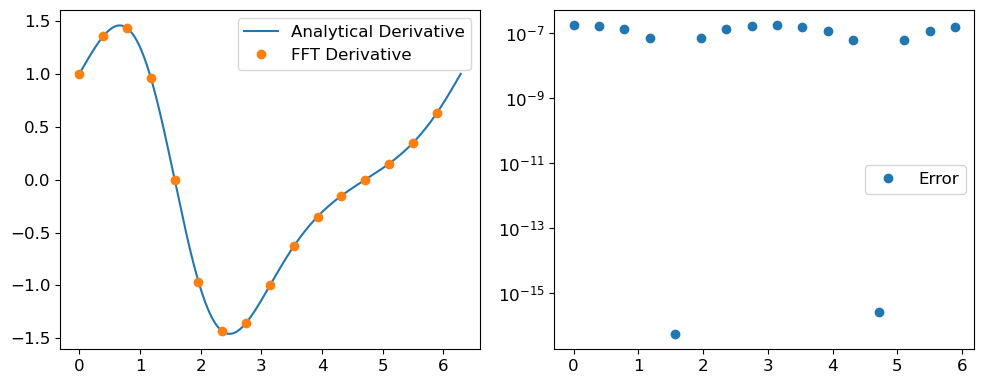

In [88]:
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

f  = exp(sin(x))
df = cos(x) * exp(sin(x))

freqs = aliased_index(np.arange(N), N) 
#Here we kill the derivative of the Nyquist mode.
#This is equivalent to Trefethen's trick in page 19.
if N % 2 == 0: 
    freqs[N//2] = 0
print(f'\nThe frequencies we are considering are: {freqs}.')
print(f'Notice we have removed the asymetric Nyquist mode.\n')

FFT_df = ifft(1j * freqs * fft(f.flatten())).real

ax[0].plot(dense_grid, cardinal_dense_functions.real @ df, label = 'Analytical Derivative')
ax[0].plot(x, FFT_df, 'o', label = 'FFT Derivative')
ax[0].legend(loc = 'upper right')

ax[1].set_yscale('log')
ax[1].plot(x, abs(FFT_df - df.flatten()), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()

## 1.6 Integration

In [96]:
abs(np.mean(fourier_spectral_basis, axis = 0))

array([1.00000000e+00, 5.65838741e-17, 3.32949082e-17, 4.14956344e-16,
       3.34221389e-16, 3.34571169e-16, 3.73781144e-16, 2.17038937e-16,
       2.83276945e-16, 2.17038937e-16, 3.73781144e-16, 3.34571169e-16,
       3.34221389e-16, 4.14956344e-16, 3.32949082e-17, 5.65838741e-17])

In [91]:
correct_int  = 7.9549265210128452728
spectral_int = 2 * pi * np.mean(f)

is_the_same(correct_int, spectral_int)

True